In [224]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

In [235]:
# Load the crop mapping dwr data 

cm = gp.read_file("../shape/Crop__Mapping_2014.shp")

# Load cv shapefile
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs

# load canals shapefile 
canals = gp.read_file("../shape/Canals_and_Aqueducts_local.shp")
canals = gp.sjoin(cvsa, canals, op = "intersects")

In [236]:
# Bar plot of of acreage by crop type in 2014
out = {}

for i in cm.DWR_Standa.unique():
    acreage = cm[cm.DWR_Standa == i]['Acres'].sum()
    out[i] = acreage*0.00404686 # acres to sq km

In [237]:
total = np.array(list(out.values())).sum()

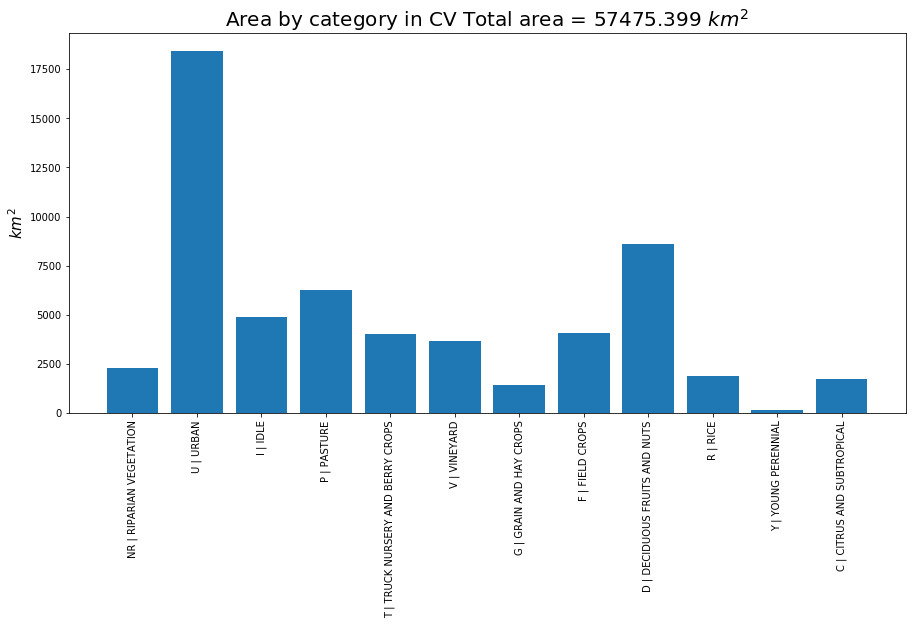

In [247]:
plt.figure(figsize=(15,7))
plt.bar(range(len(out)), out.values(), align='center')
plt.title("Area by category in CV Total area = {} $km^2$".format(str(round(total,3))), size = 20)
plt.xticks(range(len(out)), list(out.keys()),rotation='vertical')
plt.ylabel("$km^2$", size = 15)
plt.show()

In [248]:
irr_dfs = []

for i in list(cm.DWR_Standa.unique())[4:6]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[7:]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    irr_dfs.append(within_cv)

T | TRUCK NURSERY AND BERRY CROPS
V | VINEYARD
F | FIELD CROPS
D | DECIDUOUS FRUITS AND NUTS
R | RICE
Y | YOUNG PERENNIAL
C | CITRUS AND SUBTROPICAL


In [249]:
non_irr_dfs = []

for i in list(cm.DWR_Standa.unique())[:1]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[6:7]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)
    
for i in list(cm.DWR_Standa.unique())[2:4]:
    print(i)
    geoms = cm[['DWR_Standa', 'geometry']]
    crop = geoms[geoms['DWR_Standa'] == i]
    within_cv = gp.sjoin(crop, cvsa, op='within')
    non_irr_dfs.append(within_cv)

NR | RIPARIAN VEGETATION
G | GRAIN AND HAY CROPS
I | IDLE
P | PASTURE


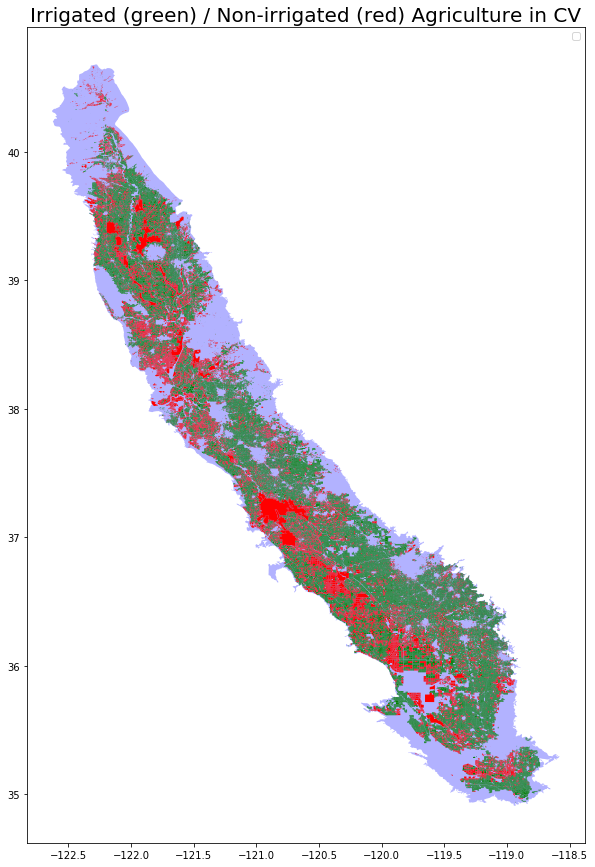

In [252]:
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(1, 1, 1)
cvsa.plot(ax=ax, color = "blue", alpha = 0.3)
canals.plot(ax = ax, color = "black", alpha = 0.8)

for i in range(len(irr_dfs)):
    irr_dfs[i].plot(ax=ax, color = "green", label = "irrigated")
    
for i in range(len(non_irr_dfs)):
    non_irr_dfs[i].plot(ax=ax, color = "red", label = "non irrigated")

ax.set_title("Irrigated (green) / Non-irrigated (red) Agriculture in CV", size = 20)

plt.legend()
plt.show()

In [ ]:
# Now Convert the irrigated acreage to earth engine multipoly and query the ET data 

In [254]:
irrigated = pd.concat(irr_dfs)
non_irrigated = pd.concat(non_irr_dfs)

In [255]:
def gdf_to_ee_multipoly(gdf):

    lls = gdf.geometry.iloc[0]
    mps = [x for x in lls]
    multipoly = []

    for i in mps: 
        x,y = i.exterior.coords.xy
        coords = [list(zip(x,y))]
        multipoly.append(coords)

    return ee.Geometry.MultiPolygon(multipoly)


def get_area(gdf):
    t = gdf.buffer(0.001).unary_union
    d  = gp.GeoDataFrame(geometry=gp.GeoSeries(t))
    d2  = gp.GeoDataFrame(geometry=gp.GeoSeries(d.simplify(0.01))) 
    area = gdf_to_ee_multipoly(d2)
    return area

In [ ]:
area_irr = get_area(irrigated)
area_non_irr = get_area(non_irr)

In [ ]:
area_irr.getInfo()

In [203]:
years = [x for x in range(2001, 2018)]
months = range(1,13)

In [229]:
data = {}

###################
##### ET data #####
###################

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD16A2
data['modis_aet'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "ET", 0.1]
data['modis_pet'] = [ee.ImageCollection('MODIS/006/MOD16A2'), "PET", 0.1]

data['gldas_aet'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 86400*30 / 240] 
data['gldas_pet'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'PotEvap_tavg', 1 / 240] 

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas_pet'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 86400*30]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
data['tc_aet'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "aet", 0.1]
data['tc_pet'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "pet", 0.1]

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET
data['gmet_etr'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "etr", 1]
data['gmet_eto'] = [ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'), "eto", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
data['fldas_aet'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "Evap_tavg", 86400*30]

###################
##### P data ######
###################

data['trmm']  =  [ee.ImageCollection('TRMM/3B43V7'), "precipitation", 720]
data['prism'] = [ee.ImageCollection("OREGONSTATE/PRISM/AN81m"), "ppt", 1]
data['chirps'] = [ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'), "precipitation", 1]
data['persia'] = [ee.ImageCollection("NOAA/PERSIANN-CDR"), "precipitation", 1]

# https://developers.google.com/earth-engine/datasets/catalog/NASA_ORNL_DAYMET_V3
data['dmet'] = [ee.ImageCollection('NASA/ORNL/DAYMET_V3'), "prcp", 1]

###################
##### SWE data #####
####################
data['swe'] = [ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001'), "SWE_inst", 1 ]

####################
##### DS data ######
####################
data['grace'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_jpl", 1]

####################
##### R data #######
####################
data['r'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "ro", 1]
data['runoff'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "Qs_tavg", 86400*24]

#####################
##### SM data #######
#####################

data['sm'] = [ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'), "soil", 0.1]

data['sm1'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi00_10cm_tavg", 1]
data['sm2'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi10_40cm_tavg", 1]
data['sm3'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi40_100cm_tavg", 1]
data['sm4'] = [ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001"), "SoilMoi100_200cm_tavg", 1]

In [256]:
def get_data(dataset, year, month, area):
    '''
    calculates the monthly sum a dataset in units of mm/time 
    '''

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
    # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
    scale = t2.projection().nominalScale()
    sumdict  = t2.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = area,
        scale = scale)
    
    result = sumdict.getInfo()[var]
    
    return result

def wrapper(dataset, area):
    
    '''
    Wrapper for `get_data` that takes a dataset and an area
    '''
    monthly = []

    for year in years:
        print(year)
        for month in months:
            r = get_data(dataset, year, month, area)
            monthly.append(r)
            time.sleep(5)
    
    print("wrapper complete")
    return monthly

def gen_polys(geometry, dx=0.5, dy=0.5):
    
    '''
    Return ee.ImaceCollection of polygons used to submit full res queries
    '''
    
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    polys = []
    
    for lon in lonlist.getInfo():
        for lat in latlist.getInfo():
        
            def make_rect(lat, lon):
                lattemp = ee.Number(lat)
                lontemp = ee.Number(lon)
                uplattemp = lattemp.add(dy)
                lowlontemp = lontemp.add(dx)

                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],[lowlontemp, lattemp],[lowlontemp, uplattemp],[lontemp, uplattemp]]))
            
            poly = make_rect(lat,lon)
            polys.append(poly)
    
    return ee.FeatureCollection(ee.List(polys))

def chunk(dataset,area):
    polys = gen_polys(area)
    d = polys.getInfo()
    results = []
    for i in d['features']:
        aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
        t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(aoi).sum()
        t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)

        scale = t2.projection().nominalScale()
        sumdict  = t2.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = aoi,
            scale = scale)

        result = sumdict.getInfo()[var]
        results.append(result)
        print('poly complete')
        
    return results


def calc_monthly_sum(dataset, years, months, area):
    
    '''
    Calculates monthly sum for hourly data. works for GLDAS / NLDAS 
    '''
    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
            
    period_start = datetime.datetime(years[0], 1, 1)
    start_date = period_start.strftime("%Y-%m-%d")
    period_end = datetime.datetime(years[-1]+1, 1, 1)
    dt_idx = pd.date_range(period_start,period_end, freq='M')
    
    sums = []
    seq = ee.List.sequence(0, len(dt_idx))
    
    for i in seq.getInfo():
        start = ee.Date(start_date).advance(i, 'month')
        end = start.advance(1, 'month');
        im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', start.millis())
        ic = im.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
        scale = ic.projection().nominalScale()
        
        sumdict  = ic.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
        total = sumdict.getInfo()[var]
        print(total)
        sums.append(total)

    return sums


In [ ]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [209]:
# Fetch all ET data - warning: takes very long
et_m = wrapper(data['modis'])
eto_g = wrapper(data['gmet_eto'])
etr_g = wrapper(data['gmet_etr'])
et_f = wrapper(data['fldas'])
et_t = wrapper(data['terra'])
# TODO: gldas, nldas

wrapper complete
wrapper complete
wrapper complete
wrapper complete
wrapper complete


In [220]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [225]:
# ET
fldas_aet = wrapper(data['fldas_aet'])
modis_pet = wrapper(data['modis_pet'])
modis_aet = wrapper(data['modis_aet'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [226]:
tc_aet = wrapper(data['tc_aet'])
tc_pet = wrapper(data['tc_pet'])

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
wrapper complete


In [232]:
gldas_pet = calc_monthly_sum(data['gldas_pet'], years, months)
gldas_aet = calc_monthly_sum(data['gldas_aet'], years, months)

1.445262216798647
1.6790543622880967
3.906245180863389
5.451574415434462
10.613134210189806
11.284656387406269
10.531186414093362
10.470391121981251
8.198851419797704
6.362112862597486
2.1838702242972325
0.9969957678348568
1.5231242796255728
2.4905101693428096
4.296542027206847
6.162227512796847
8.92010913758962
11.459480752740202
11.842825144779193
10.651664501605193
8.76667765211979
6.092152954064838
3.103924553540601
1.436348853157187
1.951876316396047
2.6652422849554442
4.700204050398363
4.707937943069658
8.544462102435299
10.908460399766046
12.071487875625587
10.448070481778215
8.927076545879295
6.882936183325226
2.512509514642731
1.2412588974567171
1.48408738506112
1.8802029476703646
5.177846183887377
7.623213469864047
9.610745604954161
11.12234717070013
11.209455911832189
10.125264633010433
8.612817347579472
4.572535477208635
2.3804420406169897
1.650280373488672
1.1959324856166196
1.968822019041957
3.8247182651222973
5.921916509188794
7.57607259372284
9.342578847881763
11.525615

In [ ]:
nldas_pet = calc_monthly_sum(data['nldas_pet'], years, months)

In [ ]:
# Make the objects into a dict 
d_aet_irr = {"fldas_aet": fldas_aet,  "gldas_aet":gldas_aet[:-1], "modis_aet":modis_aet, "tc_aet": tc_aet}
d_pet_irr = {"nldas_etr": et_n[:-1], "gldas_etr": gldas_eto[:-1], "gmet_eto": eto_g, "gmet_eto": etr_g, "modis_pet": modis_pet, "tc_pet":tc_pet}
